In [1]:

!pip install gdown timm

import gdown
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import timm
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [2]:
# Download and extract dataset
file_id = '1jsMUDlvsXWQu2BansJz73mAErVyNg_g7'
destination = '/content/shared_file.zip'
gdown.download(id=file_id, output=destination, quiet=False)

# Check if the file is indeed a ZIP file
zip_path = '/content/shared_file.zip'

try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        print("ZIP file opened successfully.")
        zip_ref.extractall('/content')
    print("Extraction complete.")
except zipfile.BadZipFile:
    print("Error: The file is not a valid ZIP file or it is corrupted.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Downloading...
From (original): https://drive.google.com/uc?id=1jsMUDlvsXWQu2BansJz73mAErVyNg_g7
From (redirected): https://drive.google.com/uc?id=1jsMUDlvsXWQu2BansJz73mAErVyNg_g7&confirm=t&uuid=fc14caca-c3cd-4828-8037-a7f3de75c35a
To: /content/shared_file.zip
100%|██████████| 1.46G/1.46G [00:32<00:00, 45.2MB/s]


ZIP file opened successfully.
Extraction complete.
Using device: cuda


In [5]:
# Custom Dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label_tensor = torch.tensor(label, dtype=torch.long)
        return img, label_tensor

# Data augmentation and preprocessing
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(90),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

test_val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load data
data_dirs = {
    'T4_Ptrain': ["l0", "l1", "l2"],
    'T4_Ptest': ["l0", "l1", "l2"]
}
data_root = "/content/T4_Pdata"

# Function to load dataset
def load_data(phase, data_dirs, data_root):
    data = []
    for label, folder in enumerate(data_dirs[phase]):
        folder_path = os.path.join(data_root, phase, folder)
        image_files = os.listdir(folder_path)
        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            data.append((image_path, label))
    return data

train_data = load_data('T4_Ptrain', data_dirs, data_root)
test_data = load_data('T4_Ptest', data_dirs, data_root)

# Split train data into training and validation sets
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=[label for _, label in train_data])

# Create datasets
train_dataset = CustomDataset(train_data, transform=train_transform)
val_dataset = CustomDataset(val_data, transform=test_val_transform)
test_dataset = CustomDataset(test_data, transform=test_val_transform)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load the model
model = timm.create_model("hf_hub:timm/swin_s3_tiny_224.ms_in1k", pretrained=True)

# Modify the final layer
num_classes = len(data_dirs['T4_Ptrain'])
model.head.fc = nn.Linear(model.head.fc.in_features, num_classes)

# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer and scheduler
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, min_lr=1e-6)

# Define loss function with class weights
class_counts = np.bincount([label for _, label in train_data])
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [6]:
# Train the model
num_epochs = 100

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        progress_bar.set_postfix({'Loss': train_loss / total, 'Accuracy': 100 * correct / total})

    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    scheduler.step(val_loss)

Epoch 1/100, Train Loss: 0.8322, Train Accuracy: 58.37%, Val Loss: 0.6815, Val Accuracy: 63.38%


Epoch 2/100, Train Loss: 0.6775, Train Accuracy: 66.43%, Val Loss: 0.6275, Val Accuracy: 68.47%


Epoch 3/100, Train Loss: 0.5855, Train Accuracy: 70.57%, Val Loss: 0.5490, Val Accuracy: 74.52%


Epoch 4/100, Train Loss: 0.4989, Train Accuracy: 77.23%, Val Loss: 0.4536, Val Accuracy: 77.87%


Epoch 5/100, Train Loss: 0.4607, Train Accuracy: 78.63%, Val Loss: 0.5021, Val Accuracy: 78.03%


Epoch 6/100, Train Loss: 0.4061, Train Accuracy: 81.74%, Val Loss: 0.3777, Val Accuracy: 80.25%


Epoch 7/100, Train Loss: 0.3360, Train Accuracy: 84.61%, Val Loss: 0.3584, Val Accuracy: 85.35%


Epoch 8/100, Train Loss: 0.3284, Train Accuracy: 85.21%, Val Loss: 0.3983, Val Accuracy: 84.24%


Epoch 9/100, Train Loss: 0.2657, Train Accuracy: 88.08%, Val Loss: 0.3544, Val Accuracy: 84.71%


Epoch 10/100, Train Loss: 0.2505, Train Accuracy: 89.47%, Val Loss: 0.3627, Val Accuracy: 84.39%


Epoch 11/100, Train Loss: 0.2249, Train Accuracy: 89.83%, Val Loss: 0.2943, Val Accuracy: 87.58%


Epoch 12/100, Train Loss: 0.1914, Train Accuracy: 91.79%, Val Loss: 0.3896, Val Accuracy: 87.10%


Epoch 13/100, Train Loss: 0.1973, Train Accuracy: 91.75%, Val Loss: 0.3106, Val Accuracy: 90.29%


Epoch 14/100, Train Loss: 0.1664, Train Accuracy: 92.70%, Val Loss: 0.3982, Val Accuracy: 87.10%


Epoch 15/100, Train Loss: 0.1341, Train Accuracy: 93.90%, Val Loss: 0.4246, Val Accuracy: 86.15%


Epoch 16/100, Train Loss: 0.1582, Train Accuracy: 92.98%, Val Loss: 0.3838, Val Accuracy: 87.26%


Epoch 17/100, Train Loss: 0.1596, Train Accuracy: 93.06%, Val Loss: 0.3523, Val Accuracy: 89.49%


Epoch 18/100, Train Loss: 0.1184, Train Accuracy: 95.10%, Val Loss: 0.3464, Val Accuracy: 89.17%


Epoch 19/100, Train Loss: 0.1102, Train Accuracy: 94.98%, Val Loss: 0.3229, Val Accuracy: 89.65%


Epoch 20/100, Train Loss: 0.1019, Train Accuracy: 95.61%, Val Loss: 0.3616, Val Accuracy: 89.33%


Epoch 21/100, Train Loss: 0.1161, Train Accuracy: 94.74%, Val Loss: 0.3683, Val Accuracy: 89.49%


Epoch 22/100, Train Loss: 0.0993, Train Accuracy: 95.89%, Val Loss: 0.4656, Val Accuracy: 85.19%


Epoch 23/100, Train Loss: 0.0735, Train Accuracy: 97.21%, Val Loss: 0.3211, Val Accuracy: 91.40%


Epoch 24/100, Train Loss: 0.0354, Train Accuracy: 98.68%, Val Loss: 0.3199, Val Accuracy: 91.88%


Epoch 25/100, Train Loss: 0.0335, Train Accuracy: 98.72%, Val Loss: 0.3205, Val Accuracy: 92.36%


Epoch 26/100, Train Loss: 0.0313, Train Accuracy: 98.60%, Val Loss: 0.3191, Val Accuracy: 91.40%


Epoch 27/100, Train Loss: 0.0289, Train Accuracy: 98.80%, Val Loss: 0.3322, Val Accuracy: 91.72%


Epoch 28/100, Train Loss: 0.0219, Train Accuracy: 99.28%, Val Loss: 0.3256, Val Accuracy: 91.88%


Epoch 29/100, Train Loss: 0.0226, Train Accuracy: 98.96%, Val Loss: 0.3592, Val Accuracy: 91.56%


Epoch 30/100, Train Loss: 0.0207, Train Accuracy: 99.24%, Val Loss: 0.3605, Val Accuracy: 91.88%


Epoch 31/100, Train Loss: 0.0171, Train Accuracy: 99.48%, Val Loss: 0.3677, Val Accuracy: 91.72%


Epoch 32/100, Train Loss: 0.0186, Train Accuracy: 99.24%, Val Loss: 0.3713, Val Accuracy: 91.88%


Epoch 33/100, Train Loss: 0.0191, Train Accuracy: 99.28%, Val Loss: 0.3897, Val Accuracy: 91.88%


Epoch 34/100, Train Loss: 0.0197, Train Accuracy: 99.24%, Val Loss: 0.3898, Val Accuracy: 91.88%


Epoch 35/100, Train Loss: 0.0141, Train Accuracy: 99.56%, Val Loss: 0.3862, Val Accuracy: 91.88%


Epoch 36/100, Train Loss: 0.0215, Train Accuracy: 99.16%, Val Loss: 0.3838, Val Accuracy: 92.04%


Epoch 37/100, Train Loss: 0.0159, Train Accuracy: 99.52%, Val Loss: 0.3833, Val Accuracy: 92.04%


Epoch 38/100, Train Loss: 0.0176, Train Accuracy: 99.36%, Val Loss: 0.3865, Val Accuracy: 92.04%


Epoch 39/100, Train Loss: 0.0131, Train Accuracy: 99.52%, Val Loss: 0.3888, Val Accuracy: 92.04%


Epoch 40/100, Train Loss: 0.0143, Train Accuracy: 99.36%, Val Loss: 0.3891, Val Accuracy: 92.04%


Epoch 41/100, Train Loss: 0.0145, Train Accuracy: 99.48%, Val Loss: 0.3910, Val Accuracy: 92.04%


Epoch 42/100, Train Loss: 0.0133, Train Accuracy: 99.32%, Val Loss: 0.3960, Val Accuracy: 92.04%


Epoch 43/100, Train Loss: 0.0176, Train Accuracy: 99.28%, Val Loss: 0.3957, Val Accuracy: 92.04%


Epoch 44/100, Train Loss: 0.0148, Train Accuracy: 99.48%, Val Loss: 0.3891, Val Accuracy: 92.04%


Epoch 45/100, Train Loss: 0.0157, Train Accuracy: 99.44%, Val Loss: 0.3863, Val Accuracy: 92.04%


Epoch 46/100, Train Loss: 0.0138, Train Accuracy: 99.56%, Val Loss: 0.3870, Val Accuracy: 92.04%


Epoch 47/100, Train Loss: 0.0167, Train Accuracy: 99.32%, Val Loss: 0.3876, Val Accuracy: 92.04%


Epoch 48/100, Train Loss: 0.0141, Train Accuracy: 99.44%, Val Loss: 0.3909, Val Accuracy: 92.04%


Epoch 49/100, Train Loss: 0.0160, Train Accuracy: 99.20%, Val Loss: 0.3895, Val Accuracy: 92.04%


Epoch 50/100, Train Loss: 0.0120, Train Accuracy: 99.56%, Val Loss: 0.3912, Val Accuracy: 92.04%


Epoch 51/100, Train Loss: 0.0134, Train Accuracy: 99.52%, Val Loss: 0.3981, Val Accuracy: 92.04%


Epoch 52/100, Train Loss: 0.0153, Train Accuracy: 99.40%, Val Loss: 0.3919, Val Accuracy: 92.04%


Epoch 53/100, Train Loss: 0.0158, Train Accuracy: 99.56%, Val Loss: 0.3901, Val Accuracy: 92.04%


Epoch 54/100, Train Loss: 0.0162, Train Accuracy: 99.20%, Val Loss: 0.4014, Val Accuracy: 92.04%


Epoch 55/100, Train Loss: 0.0108, Train Accuracy: 99.68%, Val Loss: 0.4061, Val Accuracy: 92.04%


Epoch 56/100, Train Loss: 0.0110, Train Accuracy: 99.48%, Val Loss: 0.4075, Val Accuracy: 92.04%


Epoch 57/100, Train Loss: 0.0122, Train Accuracy: 99.40%, Val Loss: 0.4137, Val Accuracy: 92.04%


Epoch 58/100, Train Loss: 0.0112, Train Accuracy: 99.64%, Val Loss: 0.4170, Val Accuracy: 92.04%


Epoch 59/100, Train Loss: 0.0137, Train Accuracy: 99.40%, Val Loss: 0.4114, Val Accuracy: 92.04%


Epoch 60/100, Train Loss: 0.0125, Train Accuracy: 99.48%, Val Loss: 0.4109, Val Accuracy: 92.04%


Epoch 61/100, Train Loss: 0.0126, Train Accuracy: 99.68%, Val Loss: 0.4082, Val Accuracy: 92.04%


Epoch 62/100, Train Loss: 0.0113, Train Accuracy: 99.48%, Val Loss: 0.4147, Val Accuracy: 92.04%


Epoch 63/100, Train Loss: 0.0118, Train Accuracy: 99.44%, Val Loss: 0.4173, Val Accuracy: 92.04%


Epoch 64/100, Train Loss: 0.0095, Train Accuracy: 99.56%, Val Loss: 0.4199, Val Accuracy: 92.04%


Epoch 65/100, Train Loss: 0.0171, Train Accuracy: 99.32%, Val Loss: 0.4101, Val Accuracy: 92.04%


Epoch 66/100, Train Loss: 0.0122, Train Accuracy: 99.48%, Val Loss: 0.4103, Val Accuracy: 92.04%


Epoch 67/100, Train Loss: 0.0100, Train Accuracy: 99.56%, Val Loss: 0.4186, Val Accuracy: 92.04%


Epoch 68/100, Train Loss: 0.0149, Train Accuracy: 99.60%, Val Loss: 0.4119, Val Accuracy: 92.04%


Epoch 69/100, Train Loss: 0.0154, Train Accuracy: 99.32%, Val Loss: 0.4184, Val Accuracy: 92.04%


Epoch 70/100, Train Loss: 0.0126, Train Accuracy: 99.56%, Val Loss: 0.4186, Val Accuracy: 92.04%


Epoch 71/100, Train Loss: 0.0096, Train Accuracy: 99.56%, Val Loss: 0.4294, Val Accuracy: 91.72%


Epoch 72/100, Train Loss: 0.0116, Train Accuracy: 99.52%, Val Loss: 0.4239, Val Accuracy: 91.88%


Epoch 73/100, Train Loss: 0.0139, Train Accuracy: 99.48%, Val Loss: 0.4191, Val Accuracy: 92.04%


Epoch 74/100, Train Loss: 0.0143, Train Accuracy: 99.32%, Val Loss: 0.4151, Val Accuracy: 92.04%


Epoch 75/100, Train Loss: 0.0117, Train Accuracy: 99.48%, Val Loss: 0.4238, Val Accuracy: 92.04%


Epoch 76/100, Train Loss: 0.0091, Train Accuracy: 99.80%, Val Loss: 0.4220, Val Accuracy: 92.04%


Epoch 77/100, Train Loss: 0.0156, Train Accuracy: 99.32%, Val Loss: 0.4194, Val Accuracy: 92.04%


Epoch 78/100, Train Loss: 0.0113, Train Accuracy: 99.64%, Val Loss: 0.4163, Val Accuracy: 92.04%


Epoch 79/100, Train Loss: 0.0087, Train Accuracy: 99.60%, Val Loss: 0.4239, Val Accuracy: 92.04%


Epoch 80/100, Train Loss: 0.0115, Train Accuracy: 99.56%, Val Loss: 0.4295, Val Accuracy: 92.04%


Epoch 81/100, Train Loss: 0.0084, Train Accuracy: 99.72%, Val Loss: 0.4351, Val Accuracy: 92.04%


Epoch 82/100, Train Loss: 0.0091, Train Accuracy: 99.56%, Val Loss: 0.4312, Val Accuracy: 92.04%


Epoch 83/100, Train Loss: 0.0114, Train Accuracy: 99.56%, Val Loss: 0.4278, Val Accuracy: 91.88%


Epoch 84/100, Train Loss: 0.0120, Train Accuracy: 99.56%, Val Loss: 0.4273, Val Accuracy: 91.88%


Epoch 85/100, Train Loss: 0.0082, Train Accuracy: 99.68%, Val Loss: 0.4294, Val Accuracy: 91.88%


Epoch 86/100, Train Loss: 0.0092, Train Accuracy: 99.68%, Val Loss: 0.4291, Val Accuracy: 92.04%


Epoch 87/100, Train Loss: 0.0106, Train Accuracy: 99.48%, Val Loss: 0.4335, Val Accuracy: 92.04%


Epoch 88/100, Train Loss: 0.0105, Train Accuracy: 99.52%, Val Loss: 0.4308, Val Accuracy: 92.04%


Epoch 89/100, Train Loss: 0.0098, Train Accuracy: 99.60%, Val Loss: 0.4375, Val Accuracy: 92.04%


Epoch 90/100, Train Loss: 0.0083, Train Accuracy: 99.68%, Val Loss: 0.4419, Val Accuracy: 92.04%


Epoch 91/100, Train Loss: 0.0082, Train Accuracy: 99.80%, Val Loss: 0.4386, Val Accuracy: 91.88%


Epoch 92/100, Train Loss: 0.0118, Train Accuracy: 99.68%, Val Loss: 0.4352, Val Accuracy: 91.88%


Epoch 93/100, Train Loss: 0.0093, Train Accuracy: 99.72%, Val Loss: 0.4421, Val Accuracy: 92.04%


Epoch 94/100, Train Loss: 0.0090, Train Accuracy: 99.64%, Val Loss: 0.4519, Val Accuracy: 91.88%


Epoch 95/100, Train Loss: 0.0097, Train Accuracy: 99.64%, Val Loss: 0.4478, Val Accuracy: 92.04%


Epoch 96/100, Train Loss: 0.0125, Train Accuracy: 99.52%, Val Loss: 0.4465, Val Accuracy: 92.04%


Epoch 97/100, Train Loss: 0.0090, Train Accuracy: 99.68%, Val Loss: 0.4494, Val Accuracy: 92.04%


Epoch 98/100, Train Loss: 0.0085, Train Accuracy: 99.56%, Val Loss: 0.4547, Val Accuracy: 92.04%


Epoch 99/100, Train Loss: 0.0068, Train Accuracy: 99.80%, Val Loss: 0.4566, Val Accuracy: 91.88%


Epoch 100/100, Train Loss: 0.0099, Train Accuracy: 99.60%, Val Loss: 0.4658, Val Accuracy: 91.88%


In [7]:
# Save the trained model
torch.save(model.state_dict(), '/content/swin_tiny_model.pth')

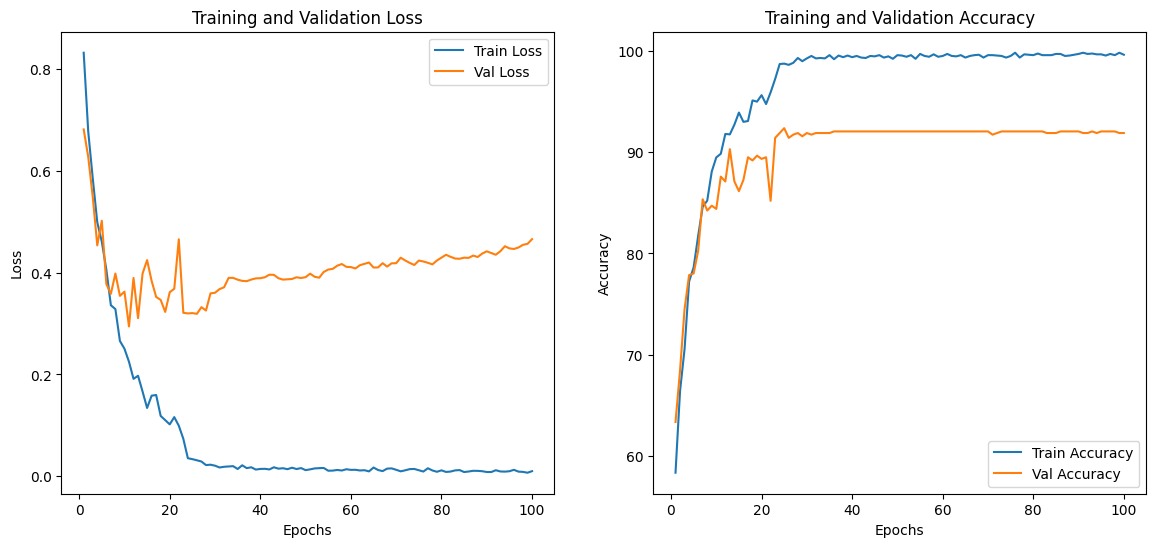

In [8]:

# Plotting training and validation losses and accuracies
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


In [9]:

# Test the model
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Evaluate the model on the test set
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted)
        true_labels.extend(labels)

# Generate classification report
true_labels = torch.tensor(true_labels).cpu().numpy()
predictions = torch.tensor(predictions).cpu().numpy()
report = classification_report(true_labels, predictions, target_names=[f"Class {i}" for i in range(num_classes)])
print(report)


Test Accuracy: 91.71%
              precision    recall  f1-score   support

     Class 0       0.89      0.86      0.87       118
     Class 1       0.95      0.94      0.94       187
     Class 2       0.91      0.93      0.92       322

    accuracy                           0.92       627
   macro avg       0.91      0.91      0.91       627
weighted avg       0.92      0.92      0.92       627



In [11]:
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
import numpy as np

# Generate classification report and confusion matrix
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=[f"Class {i}" for i in range(num_classes)]))

cm = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(cm)

# Calculate per-class metrics
TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP
TN = np.sum(cm) - (FP + FN + TP)

recall = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = TP / (TP + FP)
f1_score = 2 * precision * recall / (precision + recall)

# Calculate macro-averaged metrics
macro_recall = np.mean(recall)
macro_precision = np.mean(precision)
macro_f1_score = np.mean(f1_score)
accuracy = np.sum(TP) / np.sum(cm)
balanced_accuracy = balanced_accuracy_score(true_labels, predictions)
custom_balanced_accuracy = np.mean((recall + specificity) / 2)

# Print class-wise metrics
print("\nClass-wise Metrics:")
for i in range(len(TP)):
    print(f"Class {i}:")
    print(f"  TP: {TP[i]}")
    print(f"  TN: {TN[i]}")
    print(f"  FP: {FP[i]}")
    print(f"  FN: {FN[i]}")
    print(f"  Recall: {recall[i]:.3f}")
    print(f"  Specificity: {specificity[i]:.3f}")
    print(f"  Precision: {precision[i]:.3f}")
    print(f"  F1-score: {f1_score[i]:.3f}")

# Print macro-averaged metrics
print("\nMacro-averaged Metrics:")
print(f"Macro Recall: {macro_recall:.3f}")
print(f"Macro Precision: {macro_precision:.3f}")
print(f"Macro F1-score: {macro_f1_score:.3f}")
print(f"Accuracy (ACC): {accuracy:.3f}")
print(f"Balanced Accuracy (BAC): {balanced_accuracy:.3f}")
print(f"Custom Balanced Accuracy (BCC): {custom_balanced_accuracy:.3f}")


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.89      0.86      0.87       118
     Class 1       0.95      0.94      0.94       187
     Class 2       0.91      0.93      0.92       322

    accuracy                           0.92       627
   macro avg       0.91      0.91      0.91       627
weighted avg       0.92      0.92      0.92       627

Confusion Matrix:
[[101   0  17]
 [  0 175  12]
 [ 13  10 299]]

Class-wise Metrics:
Class 0:
  TP: 101
  TN: 496
  FP: 13
  FN: 17
  Recall: 0.856
  Specificity: 0.974
  Precision: 0.886
  F1-score: 0.871
Class 1:
  TP: 175
  TN: 430
  FP: 10
  FN: 12
  Recall: 0.936
  Specificity: 0.977
  Precision: 0.946
  F1-score: 0.941
Class 2:
  TP: 299
  TN: 276
  FP: 29
  FN: 23
  Recall: 0.929
  Specificity: 0.905
  Precision: 0.912
  F1-score: 0.920

Macro-averaged Metrics:
Macro Recall: 0.907
Macro Precision: 0.914
Macro F1-score: 0.911
Accuracy (ACC): 0.917
Balanced Accuracy (BAC): 0.907
Custo